# 📘 Entrega 2 – CNN do Zero

Este notebook apresenta uma abordagem alternativa ao uso de YOLO para detecção de objetos. Aqui, implementamos uma **Rede Neural Convolucional (CNN)** do zero utilizando TensorFlow/Keras para classificar imagens nas categorias `safety_helmet` e `drone`.

📦 Instalação de bibliotecas
Instalamos o TensorFlow e o Matplotlib, bibliotecas essenciais para criar, treinar e visualizar modelos de redes neurais convolucionais.

In [1]:
!pip install tensorflow matplotlib --quiet

🔗 Conectar ao Google Drive
Montamos o Google Drive para acessar os diretórios que contêm o dataset já preparado e organizado em subpastas por classe (cnn_dataset).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


🗂️ Definir diretórios do dataset
Especificamos os caminhos das imagens de treino e teste diretamente a partir da pasta cnn_dataset, já montada no Google Drive.



In [3]:
import os

base_path = "/content/drive/MyDrive/FIAP/FASE 6/Entrega 2/cnn_dataset"
train_dir = os.path.join(base_path, "train")
test_dir = os.path.join(base_path, "test")

🧼 Pré-processamento e aumento de dados
Usamos ImageDataGenerator para normalizar os valores dos pixels (dividindo por 255) e aplicar técnicas de data augmentation como rotação e zoom. Isso ajuda a melhorar a generalização da rede.



In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 150, 150
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 72 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


🧠 Definir arquitetura da CNN
Construímos uma CNN simples com camadas convolucionais, de pooling e densas, utilizando a API do Keras. A rede termina com uma camada softmax com 2 neurônios (uma para cada classe: safety_helmet e drone).

In [5]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,367,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,930 (9.39 MB)

 Trainable params: 2,460,930 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

🚀 Treinar o modelo
Treinamos a rede por 30 épocas, observando a acurácia e a perda tanto nos dados de treino quanto nos de validação. Isso nos ajuda a avaliar se há overfitting ou underfitting.

In [6]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5162 - loss: 0.8261 - val_accuracy: 0.4286 - val_loss: 0.7696
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6329 - loss: 0.6501 - val_accuracy: 0.5714 - val_loss: 0.6983
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5198 - loss: 0.6792 - val_accuracy: 1.0000 - val_loss: 0.6645
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6285 - loss: 0.6432 - val_accuracy: 0.4286 - val_loss: 0.7851
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6577 - loss: 0.6066 - val_accuracy: 1.0000 - val_loss: 0.4868
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6102 - loss: 0.5533 - val_accuracy: 1.0000 - val_loss: 0.4605
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7850 - loss: 0.5283 - val_accuracy: 0.8571 - val_loss: 0.4499
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 895ms/step - accuracy: 0.7944 - loss: 0.4983 - val_accuracy: 1.0000 - val_loss: 0.2949
Epoch 9/30
5

📈 Visualizar desempenho
Plotamos gráficos para acompanhar visualmente o desempenho do modelo ao longo do tempo, comparando a acurácia do treino com a de validação.



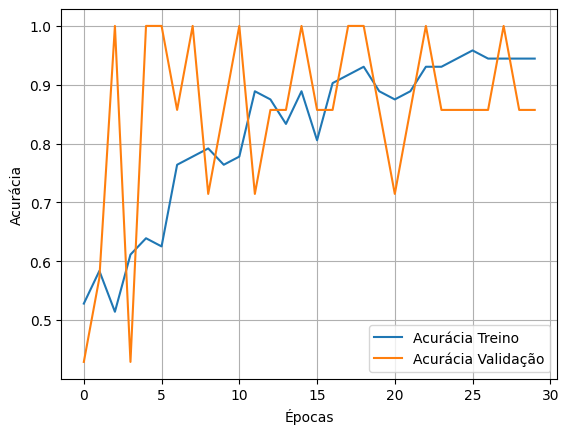

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid()
plt.show()

## 📊 Avaliação Comparativa: YOLOv5 Customizado x Pré-treinado x CNN

| Critério                          | YOLOv5 Customizado                   | YOLOv5 Pré-treinado (`yolov5s.pt`) | CNN do Zero (Keras)                  |
|----------------------------------|-------------------------------------|------------------------------------|--------------------------------------|
| **Facilidade de Uso**            | Média: exige rotulagem, `.yaml`, ajustes | Alta: basta configurar `.yaml` e caminhos | Alta: estrutura clara e integrada ao Keras |
| **Precisão (mAP)**               | Alta: `mAP@0.5 ≈ 0.62–0.67`         | Média: `mAP@0.5 ≈ 0.28`            | Alta nos dados usados: `acc ≈ 0.85–1.0` |
| **Tempo de Treinamento**        | Médio: ~30–60 épocas (~3s por época) | Rápido: pré-treinado, menos ajustes | Rápido: ~10s para 30 épocas          |
| **Tempo de Inferência (Predição)** | Muito rápido (~ms)                 | Muito rápido (~ms)                 | Razoável (segundos dependendo da imagem) |
| **Generalização**                | Boa para drones, regular para capacetes | Regular para ambas as classes      | Pode sofrer overfitting (dataset pequeno) |
| **Dependência da Estrutura YOLO**| Alta                                | Alta                               | Nenhuma                              |

---

### 🧠 Conclusão Crítica

O modelo **YOLOv5 customizado** foi o mais robusto, especialmente para a classe **drone**, com excelente recall e precisão após 60 épocas. No entanto, exigiu maior esforço de preparação, como **rotulagem manual, configuração de `.yaml`** e maior tempo de treinamento.

O **YOLOv5 pré-treinado** facilitou bastante o uso, com integração rápida ao Colab e bons resultados para protótipos. Contudo, seu desempenho foi mais limitado por **não estar ajustado ao nosso dataset**.

A **CNN do zero**, apesar de simples, **alcançou boa acurácia com baixo custo computacional**, sendo uma abordagem interessante do ponto de vista **didático**. Ainda assim, sua **capacidade de generalização** é limitada em contextos com pouca variação de dados.
